<a href="https://colab.research.google.com/github/FanCheong/MLNC-K/blob/main/Dataset_Pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup

In [3]:
import pandas as pd
import numpy as np
import math
from datetime import datetime

from category_encoders import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# 2. Data Import
Only run one, do the training, then come back to this section and run a different cell if you want to try a different dataset.

In [4]:
# Read and clean data. Convert unformatted date to appropriate string then datetime object
dataset_path = 'epl-training.csv'
df = pd.read_csv(dataset_path)
df = df.dropna(how='all')

for index, row in df.iterrows():
    date = row['Date'].split('/')
    # print(date[-1])
    if len(date[-1]) == 2:
        df.at[index, 'Date'] = f'{date[0]}/{date[1]}/20{date[-1]}'
        # print(df.at[index, 'Date'])

df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.sort_values(by=['Date'])

## 2.1 All Seasons

In [5]:
# DATASET_NAME = 'All Seasons'
# df.head()

## 2.2 Past Five Seasons (this dataset was used for the final predictions)

In [6]:
DATASET_NAME = 'Past Five Seasons'
df = df[df['Date'] > datetime(2019, 8, 1)]
df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
7221,2019-08-09,Liverpool,Norwich,4.0,1.0,H,4.0,0.0,H,M Oliver,...,7.0,5.0,11.0,2.0,9.0,9.0,0.0,2.0,0.0,0.0
7226,2019-08-10,Watford,Brighton,0.0,3.0,A,0.0,1.0,A,C Pawson,...,3.0,3.0,5.0,2.0,15.0,11.0,0.0,1.0,0.0,0.0
7227,2019-08-10,Tottenham,Aston Villa,3.0,1.0,H,0.0,1.0,A,C Kavanagh,...,7.0,4.0,14.0,0.0,13.0,9.0,1.0,0.0,0.0,0.0
7225,2019-08-10,Crystal Palace,Everton,0.0,0.0,D,0.0,0.0,D,J Moss,...,2.0,3.0,6.0,2.0,16.0,14.0,2.0,1.0,0.0,1.0
7222,2019-08-10,West Ham,Man City,0.0,5.0,A,0.0,1.0,A,M Dean,...,3.0,9.0,1.0,1.0,6.0,13.0,2.0,2.0,0.0,0.0


## 2.3 Past Two Seasons

In [7]:
# DATASET_NAME = 'Past Two Seasons'
# df = df[df['Date'] > datetime(2022, 8, 1)]
# df.head()

## 2.4 Past Season

In [8]:
DATASET_NAME = 'Past Season'
df = df[df['Date'] > datetime(2023, 8, 1)]

df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
8741,2023-08-11,Burnley,Man City,0.0,3.0,A,0.0,2.0,A,C Pawson,...,1.0,8.0,6.0,5.0,11.0,8.0,0.0,0.0,1.0,0.0
8742,2023-08-12,Arsenal,Nott'm Forest,2.0,1.0,H,2.0,0.0,H,M Oliver,...,7.0,2.0,8.0,3.0,12.0,12.0,2.0,2.0,0.0,0.0
8743,2023-08-12,Bournemouth,West Ham,1.0,1.0,D,0.0,0.0,D,P Bankes,...,5.0,3.0,10.0,4.0,9.0,14.0,1.0,4.0,0.0,0.0
8745,2023-08-12,Everton,Fulham,0.0,1.0,A,0.0,0.0,D,S Attwell,...,9.0,2.0,10.0,4.0,12.0,6.0,0.0,2.0,0.0,0.0
8746,2023-08-12,Sheffield United,Crystal Palace,0.0,1.0,A,0.0,0.0,D,J Brooks,...,1.0,8.0,5.0,5.0,18.0,11.0,3.0,0.0,0.0,0.0


## MUST RUN

In [9]:
# No need to split data randomly as we only ever pedict matches in the future. Therefore we can just take the last x% of matches as the test set.
# Splitting the data randomly could even introduce bias as we would be training on matches that happened after some the test set matches, which is not realistic.
df, df_test = np.split(df, [int(0.90 * len(df))])
len(df), len(df_test)

(152, 17)

In [10]:
df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
8741,2023-08-11,Burnley,Man City,0.0,3.0,A,0.0,2.0,A,C Pawson,...,1.0,8.0,6.0,5.0,11.0,8.0,0.0,0.0,1.0,0.0
8742,2023-08-12,Arsenal,Nott'm Forest,2.0,1.0,H,2.0,0.0,H,M Oliver,...,7.0,2.0,8.0,3.0,12.0,12.0,2.0,2.0,0.0,0.0
8743,2023-08-12,Bournemouth,West Ham,1.0,1.0,D,0.0,0.0,D,P Bankes,...,5.0,3.0,10.0,4.0,9.0,14.0,1.0,4.0,0.0,0.0
8745,2023-08-12,Everton,Fulham,0.0,1.0,A,0.0,0.0,D,S Attwell,...,9.0,2.0,10.0,4.0,12.0,6.0,0.0,2.0,0.0,0.0
8746,2023-08-12,Sheffield United,Crystal Palace,0.0,1.0,A,0.0,0.0,D,J Brooks,...,1.0,8.0,5.0,5.0,18.0,11.0,3.0,0.0,0.0,0.0


In [11]:
df_test.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
8894,2023-12-09,Sheffield United,Brentford,1.0,0.0,H,1.0,0.0,H,S Attwell,...,4.0,4.0,3.0,4.0,14.0,13.0,5.0,1.0,0.0,0.0
8892,2023-12-09,Brighton,Burnley,1.0,1.0,D,0.0,1.0,A,S Hooper,...,11.0,3.0,9.0,1.0,5.0,8.0,0.0,4.0,0.0,0.0
8891,2023-12-09,Crystal Palace,Liverpool,1.0,2.0,A,0.0,0.0,D,A Madley,...,4.0,2.0,6.0,5.0,17.0,17.0,5.0,2.0,1.0,0.0
8893,2023-12-09,Man United,Bournemouth,0.0,3.0,A,0.0,1.0,A,P Bankes,...,3.0,4.0,10.0,4.0,7.0,10.0,3.0,1.0,0.0,0.0
8897,2023-12-10,Everton,Chelsea,2.0,0.0,H,0.0,0.0,D,M Oliver,...,5.0,4.0,4.0,8.0,12.0,12.0,2.0,2.0,0.0,0.0


In [12]:
# Get list of unique teams
home_team = df["HomeTeam"].unique().tolist()
away_team = df["AwayTeam"].unique().tolist()
unique_teams = list(set(home_team + away_team))
len(unique_teams)

20

# 3. Data Transformation and Exploration
The four sections below represent the four main datasources that are taken to construct the training and testing datasets. The table name in brackets are the names of the tables that will be passed into `construct_table` which creates the training and testing sets.

## 3.1 Pi Rating (`pi_ratings`, `pairwise_pi`, `weighted_pairwise_pi`)

In [13]:
# Construct the Pi-ratings of teams from their performance in the training dataset. The specific equations can be found in the report.
def calc_pi_rating(home_team_ratings: pd.DataFrame, away_team_ratings: pd.DataFrame, ft_home_goals, ft_away_goals, decay_factor):
    C = 3
    LOG_BASE = 10
    # Hyperparameters set after tuning
    LAMBDA = 0.156
    GAMMA = 0.739

    # Initialise the updated ratings to the current ratings
    updated_home_team_ratings = home_team_ratings.copy()
    updated_away_team_ratings = away_team_ratings.copy()

    home_team_sign = 1 if home_team_ratings['HomeRating'].values[0] >= 0 else -1
    away_team_sign = 1 if away_team_ratings['AwayRating'].values[0] >= 0 else -1

    # Calculate the expected goal difference based on team's current ratings
    exp_home_goal_diff = home_team_sign * (LOG_BASE ** (abs(home_team_ratings['HomeRating'].values[0]) / C) - 1)
    exp_away_goal_diff = away_team_sign * (LOG_BASE ** (abs(away_team_ratings['AwayRating'].values[0]) / C) - 1)

    exp_goal_diff = exp_home_goal_diff - exp_away_goal_diff
    act_goal_diff = ft_home_goals - ft_away_goals

    # Error between expected and actual goal difference
    error = abs(act_goal_diff - exp_goal_diff)

    # Calculate by how much ratings should be updated
    if act_goal_diff > exp_goal_diff:
        psi_H_e = C * math.log10(error + 1)
        psi_A_e = -C * math.log10(error + 1)
    else:
        psi_H_e = -C * math.log10(error + 1)
        psi_A_e = C * math.log10(error + 1)

    # Expontential time decay to weight more recent matches more heavily
    psi_H_e *= decay_factor
    psi_A_e *= decay_factor

    # Update the ratings
    updated_home_team_ratings['HomeRating'].values[0] = home_team_ratings['HomeRating'].values[0] + psi_H_e * LAMBDA
    updated_away_team_ratings['AwayRating'].values[0] = away_team_ratings['AwayRating'].values[0] + psi_A_e * LAMBDA

    updated_home_team_ratings['AwayRating'].values[0] = home_team_ratings['AwayRating'].values[0] + (updated_home_team_ratings['HomeRating'].values[0] - home_team_ratings['HomeRating'].values[0]) * GAMMA
    updated_away_team_ratings['HomeRating'].values[0] = away_team_ratings['HomeRating'].values[0] + (updated_away_team_ratings['AwayRating'].values[0] - away_team_ratings['AwayRating'].values[0]) * GAMMA

    return updated_home_team_ratings, updated_away_team_ratings

In [14]:
# Evaluate how teams fare against each other in both home and away contexts by calculating unique ratings for every possible pair of teams. This takes into account the specific dynamics of each head-to-head encounter.
def calc_pair_pi_rating(home_team_ratings: pd.DataFrame, away_team_ratings: pd.DataFrame, ft_home_goals, ft_away_goals, decay_factor):
    updated_home_team_ratings,  updated_away_team_ratings = calc_pi_rating(home_team_ratings, away_team_ratings, ft_home_goals, ft_away_goals, decay_factor)
    hh_rating, ha_rating, ah_rating, aa_rating = updated_home_team_ratings['HomeRating'].values[0], updated_home_team_ratings['AwayRating'].values[0], updated_away_team_ratings['HomeRating'].values[0], updated_away_team_ratings['AwayRating'].values[0]
    updated_home_team_ratings['HomeRating'].values[0] = hh_rating
    updated_home_team_ratings['AwayRating'].values[0] = aa_rating
    updated_away_team_ratings['HomeRating'].values[0] = ah_rating
    updated_away_team_ratings['AwayRating'].values[0] = ha_rating
    return updated_home_team_ratings, updated_away_team_ratings

In [15]:
# Iterate over the dataset to calculate and return the ratings
def get_ratings(data):
    ALPHA = 0.999
    BETA = 0.5

    # Initialise ratings to 0 and get the latest date in the dataset for time decay
    latest_date = pd.to_datetime(data['Date']).max()
    pi_ratings = pd.DataFrame(unique_teams, columns=['Team'])
    pi_ratings['HomeRating'] = 0.0
    pi_ratings['AwayRating'] = 0.0

    # Create a dataframe to store pairwise ratings
    matchups = [
        (home_team, away_team)
        for home_team in pi_ratings['Team']
        for away_team in pi_ratings['Team']
        if (home_team != away_team and pd.notna(home_team) and pd.notna(away_team))
    ]

    pairwise_pi = pd.DataFrame(matchups, columns=['HomeTeam', 'AwayTeam'])
    pairwise_pi['HomeRating'] = 0.0
    pairwise_pi['AwayRating'] = 0.0

    # Iterate over the dataset to calculate the ratings
    for index, row in data.iterrows():

        if pd.isnull(row['HomeTeam']):
            continue

        team1 = row['HomeTeam']
        team2 = row['AwayTeam']

        # Add exponential time decay to the ratings
        time_diff = (latest_date - pd.to_datetime(row['Date'])).days
        decay_factor = ALPHA ** time_diff

        # Update individual ratings
        team1_rating = pi_ratings.loc[pi_ratings['Team'] == team1]
        team2_rating = pi_ratings.loc[pi_ratings['Team'] == team2]

        # Update pairwise ratings
        pair_rating = pairwise_pi.loc[(pairwise_pi['HomeTeam'] == team1) & (pairwise_pi['AwayTeam'] == team2)]
        cross_pair_rating = pairwise_pi.loc[(pairwise_pi['HomeTeam'] == team2) & (pairwise_pi['AwayTeam'] == team1)]

        updated_team1_rating, updated_team2_rating = calc_pi_rating(team1_rating, team2_rating, row['FTHG'], row['FTAG'], decay_factor)
        updated_pair_rating, updated_cross_pair_rating = calc_pair_pi_rating(pair_rating, cross_pair_rating, row['FTHG'], row['FTAG'], decay_factor)

        pi_ratings.loc[pi_ratings['Team'] == team1] = updated_team1_rating
        pi_ratings.loc[pi_ratings['Team'] == team2] = updated_team2_rating
        pairwise_pi.loc[(pairwise_pi['HomeTeam'] == team1) & (pairwise_pi['AwayTeam'] == team2), \
                        ['HomeRating', 'AwayRating']] = updated_pair_rating['HomeRating'].values[0], updated_pair_rating['AwayRating'].values[0]
        pairwise_pi.loc[(pairwise_pi['HomeTeam'] == team2) & (pairwise_pi['AwayTeam'] == team1), \
                        ['HomeRating', 'AwayRating']] = updated_cross_pair_rating['HomeRating'].values[0], updated_cross_pair_rating['AwayRating'].values[0]

    # Create another dataframe to store weighted ratings where the HomeRating for HomeTeam is the weighted average of pairwise ratings of HomeTeam HomeRating and pi_ratings HomeTeam HomeRating
    weighted_pairwise_pi = pairwise_pi.copy()

    # Iterate over the pairwise ratings to calculate the weighted ratings of pairwise and individual ratings
    for index, row in weighted_pairwise_pi.iterrows():
        team1 = row['HomeTeam']
        team2 = row['AwayTeam']

        # HomeTeam home, HomeTeam away, AwayTeam home, AwayTeam away
        ht_homerating = pi_ratings.loc[pi_ratings['Team'] == team1]['HomeRating'].values[0]
        ht_awayrating = pi_ratings.loc[pi_ratings['Team'] == team1]['AwayRating'].values[0]
        at_homerating = pi_ratings.loc[pi_ratings['Team'] == team2]['HomeRating'].values[0]
        at_awayrating = pi_ratings.loc[pi_ratings['Team'] == team2]['AwayRating'].values[0]

        # Pairwise HomeTeam home, Pairwise HomeTeam away, Pairwise AwayTeam home, Pairwise AwayTeam away
        pwht_homerating = pairwise_pi.loc[(pairwise_pi['HomeTeam'] == team1) & (pairwise_pi['AwayTeam'] == team2)]['HomeRating'].values[0]
        pwht_awayrating = pairwise_pi.loc[(pairwise_pi['HomeTeam'] == team2) & (pairwise_pi['AwayTeam'] == team1)]['AwayRating'].values[0]
        pwat_homerating = pairwise_pi.loc[(pairwise_pi['HomeTeam'] == team2) & (pairwise_pi['AwayTeam'] == team1)]['HomeRating'].values[0]
        pwat_awayrating = pairwise_pi.loc[(pairwise_pi['HomeTeam'] == team1) & (pairwise_pi['AwayTeam'] == team2)]['AwayRating'].values[0]

        # Weighted pairwise HomeTeam home, Weighted pairwise HomeTeam away, Weighted pairwise AwayTeam home, Weighted pairwise AwayTeam away
        wpwht_homerating = ht_homerating * BETA + pwht_homerating
        wpwht_awayrating = ht_awayrating * BETA + pwht_awayrating
        wpwat_homerating = at_homerating * BETA + pwat_homerating
        wpwat_awayrating = at_awayrating * BETA + pwat_awayrating

        weighted_pairwise_pi.loc[(weighted_pairwise_pi['HomeTeam'] == team1) & (weighted_pairwise_pi['AwayTeam'] == team2), \
                        ['HomeRating', 'AwayRating']] = wpwht_homerating, wpwat_awayrating
        weighted_pairwise_pi.loc[(weighted_pairwise_pi['HomeTeam'] == team2) & (weighted_pairwise_pi['AwayTeam'] == team1), \
                        ['HomeRating', 'AwayRating']] = wpwat_homerating, wpwht_awayrating

    return (pi_ratings, pairwise_pi, weighted_pairwise_pi)

In [16]:
# Simple pi ratings, pairwise pi ratings and weighted pairwise pi ratings
pi_ratings, pairwise_pi, weighted_pairwise_pi = get_ratings(df)

In [17]:
pi_ratings.loc[(pi_ratings['Team'] == 'Man United') | (pi_ratings['Team'] == 'Man City')].sort_index(ascending=False)

,Team,HomeRating,AwayRating
15,Man United,0.228420,0.224445
12,Man City,0.796551,0.638488


In [18]:
pairwise_pi.loc[(pairwise_pi['HomeTeam'] == 'Man United') & (pairwise_pi['AwayTeam'] == 'Man City') | (pairwise_pi['HomeTeam'] == 'Man City') & (pairwise_pi['AwayTeam'] == 'Man United')].sort_index(ascending=False)

,HomeTeam,AwayTeam,HomeRating,AwayRating
297,Man United,Man City,-0.270440,0.270440
242,Man City,Man United,0.199855,-0.199855


In [19]:
weighted_pairwise_pi.loc[(weighted_pairwise_pi['HomeTeam'] == 'Man United') & (weighted_pairwise_pi['AwayTeam'] == 'Man City') | (weighted_pairwise_pi['HomeTeam'] == 'Man City') & (weighted_pairwise_pi['AwayTeam'] == 'Man United')].sort_index(ascending=False)

,HomeTeam,AwayTeam,HomeRating,AwayRating
297,Man United,Man City,-0.15623,0.589684
242,Man City,Man United,0.59813,-0.087633


## 3.2 Data Averaging (`data_avg`)

In [20]:
# Create a dictionary for teams scores
team_scores = {team: 0 for team in unique_teams}

for index, row in df.iterrows():
    if pd.isnull(row['HomeTeam']):
        continue

    team_scores[row['HomeTeam']] += row['FTHG']
    team_scores[row['AwayTeam']] += row['FTAG']

print(team_scores)

{'Luton': 16.0, 'Newcastle': 32.0, 'Brighton': 32.0, 'Bournemouth': 18.0, 'Aston Villa': 35.0, 'Liverpool': 34.0, 'Fulham': 21.0, 'Sheffield United': 11.0, 'Crystal Palace': 14.0, 'Tottenham': 29.0, "Nott'm Forest": 17.0, 'Everton': 18.0, 'Man City': 36.0, 'West Ham': 26.0, 'Burnley': 15.0, 'Man United': 18.0, 'Arsenal': 33.0, 'Brentford': 23.0, 'Chelsea': 26.0, 'Wolves': 21.0}


In [21]:
# Create the following feature for each team
# - AvgGoalDiff Average goal difference between the two teams in the previous six games>
# - TotalGoalDiff Goal difference between the two teams in the previous six games>
# - AvgShotSta Standard deviation of shots on goal for both sides in six matches
# - AvgTargetSta Standard deviation of shots on target for both sides in six matches
# - ShotAccSta Standard deviation of shot accuracy between the home team and the away team
# - AvgCornerSta Standard deviation of corners for both sides in six matches
# - AvgFoulSta Standard deviation of fouls for both sides in six matches

from itertools import combinations
reversed_df = df[::-1]
def get_previous_matches(team_name):
    team_matches = reversed_df[(reversed_df['HomeTeam'] == team_name) | (reversed_df['AwayTeam'] == team_name)]
    return team_matches

# Calculate average goals for each team in their previous six games
teams = df['HomeTeam'].unique().tolist() + df['AwayTeam'].unique().tolist()
teams = list(set(teams))  # Remove duplicates

average_goals = {}
total_goals = {}
std_dev_shots_on_goal = {}
for team in teams:
    team_df = get_previous_matches(team)
    total= team_df.loc[team_df['HomeTeam'] == team, 'FTHG'].sum() + team_df.loc[team_df['AwayTeam'] == team, 'FTAG'].sum()
    matches_played = len(team_df)
    average_goals[team] = total / matches_played if matches_played > 0 else 0
    total_goals[team] = total

# Calculate differences between each team's average goals in their previous six games
print(average_goals)
team_combinations = combinations(average_goals.keys(), 2)  # Get all combinations of teams
team_differences_avgGoal = {}
team_differences_totalGoal= {}
std_dev_ST = {}
std_dev_C = {}
std_dev_F ={}

# Iterate over all combinations of teams and calculate pairwise statistics
for team1 in teams:
    for team2 in teams:
        if team1 == team2:
            continue

        # Calculate the difference in average goals and total goals
        difference_avg = abs(average_goals[team1] - average_goals[team2])
        difference_total = abs(total_goals[team1] - total_goals[team2])
        team_differences_avgGoal[f"{team1} - {team2}"] = difference_avg
        team_differences_totalGoal[f"{team1} - {team2}"] = difference_total

        team1_df = get_previous_matches(team1)
        team2_df = get_previous_matches(team2)

        # Shots for both teams
        team1_HS = team1_df.loc[team1_df['HomeTeam'] ==team1, 'HS']
        team1_AS = team1_df.loc[team1_df['AwayTeam'] == team1, 'AS']
        team2_HS = team2_df.loc[team2_df['HomeTeam'] ==team2, 'HS']
        team2_AS = team2_df.loc[team2_df['AwayTeam'] == team2, 'AS']
        team1_combined = pd.concat([team1_HS, team1_AS], axis=0)
        team2_combined = pd.concat([team2_HS, team2_AS], axis=0)

        # Shots on target for both teams
        team1_HST =team1_df.loc[team1_df['HomeTeam'] ==team1, 'HST']
        team1_AST =team1_df.loc[team1_df['AwayTeam'] == team1, 'AST']
        team2_HST = team2_df.loc[team2_df['HomeTeam'] == team2, 'HST']
        team2_AST = team2_df.loc[team2_df['AwayTeam'] == team2, 'AST']
        team1_AST_combined = pd.concat([team1_HST, team1_AST], axis=0)
        team2_AST_combined = pd.concat([team2_HST, team2_AST], axis=0)

        # Corners for both teams
        team1_HC =team1_df.loc[team1_df['HomeTeam'] ==team1, 'HC']
        team1_AC =team1_df.loc[team1_df['AwayTeam'] == team1, 'AC']
        team2_HC = team2_df.loc[team2_df['HomeTeam'] == team2, 'HC']
        team2_AC = team2_df.loc[team2_df['AwayTeam'] == team2, 'AC']
        team1_AC_combined = pd.concat([team1_HC, team1_AC], axis=0)
        team2_HC_combined = pd.concat([team2_HC, team2_AC], axis=0)

        # Fouls for both teams
        team1_HF =team1_df.loc[team1_df['HomeTeam'] ==team1, 'HF']
        team1_AF =team1_df.loc[team1_df['AwayTeam'] == team1, 'AF']
        team2_HF = team2_df.loc[team2_df['HomeTeam'] == team2, 'HF']
        team2_AF = team2_df.loc[team2_df['AwayTeam'] == team2, 'AF']
        team1_F_combined = pd.concat([team1_HF, team1_AF], axis=0)
        team2_F_combined = pd.concat([team2_HF, team2_AF], axis=0)


        # Combine both team dataframes into one
        combined_df = pd.concat([team1_combined, team2_combined], axis=0)
        combined_df_AST = pd.concat([team1_AST_combined, team2_AST_combined], axis=0)
        combined_df_AC = pd.concat([team1_AC_combined, team2_HC_combined], axis=0)
        combined_df_F = pd.concat([team1_F_combined, team2_F_combined], axis=0)

        # Calculate the standard deviations of above metrics
        std_dev = combined_df.std()
        std_dev_AST = combined_df_AST.std()
        std_dev_Corner = combined_df_AC.std()
        std_dev_Foul = combined_df_F.std()

        std_dev_shots_on_goal[f"{team1} - {team2}"] = std_dev
        std_dev_ST[f"{team1} - {team2}"] = std_dev_AST
        std_dev_C[f"{team1} - {team2}"] = std_dev_Corner
        std_dev_F[f"{team1} - {team2}"] = std_dev_Foul


{'Luton': 1.0666666666666667, 'Newcastle': 2.1333333333333333, 'Brighton': 2.1333333333333333, 'Bournemouth': 1.2, 'Aston Villa': 2.1875, 'Liverpool': 2.2666666666666666, 'Fulham': 1.4, 'Sheffield United': 0.7333333333333333, 'Crystal Palace': 0.9333333333333333, 'Tottenham': 1.9333333333333333, "Nott'm Forest": 1.0625, 'Everton': 1.2, 'Man City': 2.4, 'West Ham': 1.7333333333333334, 'Burnley': 1.0, 'Man United': 1.2, 'Arsenal': 2.0625, 'Brentford': 1.5333333333333334, 'Chelsea': 1.7333333333333334, 'Wolves': 1.3125}


In [22]:
columns_1 = {'Team1': [], 'Team2': []}
data_avg = pd.DataFrame(columns=columns_1.keys())

rows = []
for pair, avg in team_differences_avgGoal.items():
    team_name = pair.split(' - ')
    new_row = {'Team1': team_name[0], 'Team2': team_name[1], 'AvgGoalDiff6Matches': avg}
    rows.append(new_row)

data_avg = pd.DataFrame(rows)
data_avg['TotalGoalDiff6Matches'] = list(team_differences_totalGoal.values())
data_avg['AvgShotSta'] = list(std_dev_shots_on_goal.values())
data_avg['AvgTargetSta'] = list(std_dev_ST.values())
data_avg['AvgCornerSta'] = list(std_dev_C.values())
data_avg['AvgFoulSta'] = list(std_dev_F.values())

averages = data_avg[(data_avg['Team1'] == 'Crystal Palace')]
averages.head()

,Team1,Team2,AvgGoalDiff6Matches,TotalGoalDiff6Matches,AvgShotSta,AvgTargetSta,AvgCornerSta,AvgFoulSta
152,Crystal Palace,Luton,0.133333,2.0,4.825817,2.237610,2.621967,2.918234
153,Crystal Palace,Newcastle,1.200000,18.0,5.432554,3.484778,2.661777,3.791855
154,Crystal Palace,Brighton,1.200000,18.0,5.703901,2.960467,3.382851,3.308123
155,Crystal Palace,Bournemouth,0.266667,4.0,4.811504,2.725782,2.976730,3.393029
156,Crystal Palace,Aston Villa,1.254167,21.0,4.528049,2.358239,2.967567,3.492542


## 3.3 Home and Away Stats (`away_wins_dic`, `home_wins_dic`, `away_draws_dic`, `home_draws_dic`)

In [23]:
# Identifying the amount of times the home team won at home, drew at home. Same for away team

home_wins = df[df['FTR'] == 'H']
home_wins_count = home_wins['HomeTeam'].value_counts()
home_wins_count

home_draw = df[df['FTR'] == 'D']
home_draw_count = home_draw['HomeTeam'].value_counts()

away_wins = df[df['FTR'] == 'A']
away_wins_count = away_wins['AwayTeam'].value_counts()

away_draw = df[df['FTR'] == 'D']
away_draw_count = away_draw['AwayTeam'].value_counts()

home_wins_dic = {team:0 for team in unique_teams}
home_draw_dic = {team:0 for team in unique_teams}
away_wins_dic ={team:0 for team in unique_teams}
away_draw_dic = {team:0 for team in unique_teams}

def fillDic(series, dic):
  for team, count in series.items():
    dic[team] = count
  return dic

home_wins_dic =fillDic(home_wins_count, home_wins_dic)
home_draw_dic =fillDic(home_draw_count, home_draw_dic)
away_wins_dic = fillDic(away_wins_count, away_wins_dic)
away_draw_dic = fillDic(away_draw_count , away_draw_dic)

# home_wins_dic
away_wins_dic
away_wins_df = pd.DataFrame(list(away_wins_dic.items()), columns=['Team', 'AwayWins'])
away_wins_df.head()

,Team,AwayWins
0,Luton,1
1,Newcastle,1
2,Brighton,3
3,Bournemouth,2
4,Aston Villa,3


## 3.4 Team Stats (`team_stats`)

In [24]:
# Create a dictionary for team wins, loss, draw to calculate individual team statistics

team_wins = {team:0 for team in unique_teams}
team_loss = {team:0 for team in unique_teams}
team_draw = {team:0 for team in unique_teams}

for index, row in df.iterrows():
  if pd.isnull(row['HomeTeam']):
    continue

  if row['FTR'] == "H":
    team_wins[row["HomeTeam"]] += 1
    team_loss[row["AwayTeam"]] += 1
  elif row['FTR'] == "A":
    team_wins[row["AwayTeam"]] += 1
    team_loss[row["HomeTeam"]] += 1
  elif row['FTR'] == "D":
    team_draw[row['HomeTeam']] += 1
    team_draw[row['AwayTeam']] += 1

In [25]:
# Calculate the individual team statistics
team_goals_HT  = {team:0 for team in unique_teams}
team_shots_on_goal = {team:0 for team in unique_teams}
team_shots_on_target ={team:0 for team in unique_teams}
team_yellow_card ={team:0 for team in unique_teams}
team_red_card = {team:0 for team in unique_teams}
team_corners ={team:0 for team in unique_teams}
team_fouls = {team:0 for team in unique_teams}
team_seasons = {team:set() for team in unique_teams}

for index, row in df.iterrows():
  if pd.isnull(row['HomeTeam']):
    continue

  team_goals_HT[row['HomeTeam']] += row['HTHG']
  team_goals_HT[row['AwayTeam']] += row['HTAG']

  team_shots_on_goal[row['HomeTeam']] += row['HS']
  team_shots_on_goal[row['AwayTeam']] += row['AS']

  team_shots_on_target[row['HomeTeam']] += row['HST']
  team_shots_on_target[row['AwayTeam']] += row['AST']

  team_yellow_card[row['HomeTeam']] += row['HY']
  team_yellow_card[row['AwayTeam']] += row['AY']

  team_red_card[row['HomeTeam']] += row['HR']
  team_red_card[row['AwayTeam']] += row['AR']

  team_corners[row['HomeTeam']] += row['HC']
  team_corners[row['HomeTeam']] += row['AC']

  team_fouls[row['HomeTeam']] += row['HF']
  team_fouls[row['AwayTeam']] += row['AF']

  team_seasons[row['HomeTeam']].add(row['Date'].year)
  team_seasons[row['AwayTeam']].add(row['Date'].year)

print(team_seasons[row['HomeTeam']])

{2023}


In [26]:
# Load team statistics into dataframe
column_names = ['Team', '# Matches', 'Wins' , 'Draw', 'Loss', 'Shots on Goal', 'Shots on Target', 'Total Yellow Card' ,'Total Red Card' , 'Corners', 'Fouls', 'Total Goals' ,'Total Goals Half-Time', '# Active Seasons', 'Sht%']
team_stats_df = pd.DataFrame(columns=column_names)
team_stats_df['Team'] = unique_teams
team_stats_df['# Matches'] = [team_wins[team] + team_loss[team] + team_draw[team] for team in unique_teams]
team_stats_df['Wins'] = list(team_wins.values())
team_stats_df['Draw'] = list(team_draw.values())
team_stats_df['Loss'] = list(team_loss.values())
team_stats_df['Shots on Goal'] = list(team_shots_on_goal.values())
team_stats_df['Shots on Target'] = list(team_shots_on_target.values())
team_stats_df['Sht%'] = team_stats_df['Shots on Target'] / team_stats_df['Shots on Goal']
team_stats_df['Total Yellow Card'] = list(team_yellow_card.values())
team_stats_df['Total Red Card'] = list(team_red_card.values())
team_stats_df['Corners'] = list(team_corners.values())
team_stats_df['Fouls'] = list(team_fouls.values())
team_stats_df['Total Goals'] = list(team_scores.values())
team_stats_df['Total Goals Half-Time'] = list(team_goals_HT.values())
team_stats_df['# Active Seasons'] = [len(team_seasons[team]) for team in unique_teams]

# 4. Metholodogy Overview
Combine features of different dimensions to create a single table that captures individual team stats and team vs team stats. Use this table to train a classifier to predict the FTRs of matches.

## 4.1 Constructing the Training and Testing Sets

In [27]:
# Driver function to construct training and test dataframes from the metrics and statistics calculated above
def construct_table(data, team_stats, away_wins_dic, home_wins_dic, away_draws_dic, home_draws_dic, data_avg, pi_ratings, pairwise_pi, weighted_pairwise_pi):
    table = pd.DataFrame(columns = ['HomeTeam', 'AwayTeam', 'HomeTeamWin%',
                                    'AwayTeam%', 'HomeTeamDraw%', 'AwayTeamDraw%',
                                    'HomeHWin%', 'HomeHDraw%', 'AwayHWin%', 'AwayHDraw%',
                                    'HomeTeamShotOnGoalPerMatch', 'AwayTeamShotOnGoalPerMatch',
                                    'HomeTeamGoalsPerMatch', 'AwayTeamGoalsPerMatch',
                                    'HomeTeamHalfTimeGoalsPerMatch', 'AwayTeamHalfTimeGoalsPerMatch',
                                    'AvgGoalDiff6Matches', 'TotalGoalDiff6Matches',
                                    'AvgShotSta', 'AvgTargetSta', 'AvgCornerSta', 'AvgFoulSta',
                                    'HT_HomeRating',    'HT_AwayRating',    'AT_HomeRating',    'AT_AwayRating',
                                    'PWHT_HomeRating',  'PWHT_AwayRating',  'PWAT_HomeRating',  'PWAT_AwayRating',
                                    'WPWHT_HomeRating', 'WPWHT_AwayRating', 'WPWAT_HomeRating', 'WPWAT_AwayRating'])

    # Identify numeric columns
    numeric_columns = team_stats.select_dtypes(include=[np.number]).columns
    # Calculate average for numeric columns only

    average_stats = team_stats[numeric_columns].mean()

    for index,row in data.iterrows():

        if pd.isnull(row['Date']):
            continue

        team1 = row['HomeTeam']
        team2 = row['AwayTeam']
        date = row['Date']

        team1_data = team_stats[team_stats['Team'] == team1]
        team2_data = team_stats[team_stats['Team'] == team2]

        if team1_data.empty:
            # If a team is not present, create a new row with average values for numeric columns and convert do a DataFrame
            new_row = {col: average_stats[col] for col in numeric_columns}
            new_row['Team'] = team1
            team1_data = pd.DataFrame([new_row])

        if team2_data.empty:
            # Create a new row with average values for numeric columns and convert do a DataFrame
            new_row = {col: average_stats[col] for col in numeric_columns}
            new_row['Team'] = team2
            team2_data = pd.DataFrame([new_row])

        team1_matches_played = team1_data['# Matches'].values[0]
        team2_matches_played = team2_data['# Matches'].values[0]

        #HomeShotOnGoalPerMatch, #AwayTeamShotOnGoalPerMatch
        team1_shots_on_goal_per_match = team1_data['Shots on Goal'].values[0] / team1_matches_played
        team2_shots_on_goal_per_match = team2_data['Shots on Goal'].values[0] / team2_matches_played

        #HomeTeamGoalsPerMatch, AwayTeamGoalsPerMatch
        team1_goals_per_match = team1_data['Total Goals'].values[0] / team1_matches_played
        team2_goals_per_match = team2_data['Total Goals'].values[0] / team2_matches_played

        #HomeTeamHalfTimeGoalsPerMatch, #AwayTeamHalfTimeGoalsPerMatch
        team1_halftime_goals = team1_data['Total Goals Half-Time'].values[0] / team1_matches_played
        team2_halftime_goals = team2_data['Total Goals Half-Time'].values[0] / team2_matches_played

        #HomeTeamWin%, AwayTeamWin%
        home_win = (team1_data['Wins'].values[0] / team1_matches_played) * 100
        away_win = (team2_data['Wins'].values[0] / team2_matches_played) * 100

        #HomeDraw%, AwayDraw%
        home_draw = (team1_data['Draw'].values[0] / team1_matches_played) * 100
        away_draw = (team2_data['Draw'].values[0]/ team2_matches_played) * 100

        #HomeHWin
        homeh_win = (home_wins_dic[team1] / team1_matches_played) * 100 if team1 in home_wins_dic else 0
        homeh_draw = (home_draws_dic[team1] / team1_matches_played) * 100 if team1 in home_draws_dic else 0

        #AwayHWin
        awayh_win = (away_wins_dic[team2] / team2_matches_played) * 100 if team2 in away_wins_dic else 0
        awayh_draw = (away_draws_dic[team2] / team2_matches_played) * 100 if team2 in away_draws_dic else 0

        averages = data_avg[(data_avg['Team1'] == team1) & (data_avg['Team2'] == team2)]

        def get_value_or_default(df, column, default=0):
            return df[column].values[0] if not df.empty else default

        #AvgGoalDiff
        avg_goal_diff = get_value_or_default(averages, 'AvgGoalDiff6Matches')
        total_goal_diff = get_value_or_default(averages, 'TotalGoalDiff6Matches')
        avg_shot = get_value_or_default(averages, 'AvgShotSta')
        avg_target = get_value_or_default(averages, 'AvgTargetSta')
        avg_corner = get_value_or_default(averages, 'AvgCornerSta')
        avg_foul = get_value_or_default(averages, 'AvgFoulSta')

        # HomeTeam home, HomeTeam away, AwayTeam home, AwayTeam away
        ht_homerating = get_value_or_default(pi_ratings[pi_ratings['Team'] == team1], 'HomeRating')
        ht_awayrating = get_value_or_default(pi_ratings[pi_ratings['Team'] == team1], 'AwayRating')
        at_homerating = get_value_or_default(pi_ratings[pi_ratings['Team'] == team2], 'HomeRating')
        at_awayrating = get_value_or_default(pi_ratings[pi_ratings['Team'] == team2], 'AwayRating')

        # Pairwise HomeTeam home, Pairwise HomeTeam away, Pairwise AwayTeam home, Pairwise AwayTeam away
        pwht_homerating = get_value_or_default(pairwise_pi[(pairwise_pi['HomeTeam'] == team1) & (pairwise_pi['AwayTeam'] == team2)], 'HomeRating')
        pwht_awayrating = get_value_or_default(pairwise_pi[(pairwise_pi['HomeTeam'] == team2) & (pairwise_pi['AwayTeam'] == team1)], 'AwayRating')
        pwat_homerating = get_value_or_default(pairwise_pi[(pairwise_pi['HomeTeam'] == team2) & (pairwise_pi['AwayTeam'] == team1)], 'HomeRating')
        pwat_awayrating = get_value_or_default(pairwise_pi[(pairwise_pi['HomeTeam'] == team1) & (pairwise_pi['AwayTeam'] == team2)], 'AwayRating')

        # Weighted pairwise HomeTeam home, Weighted pairwise HomeTeam away, Weighted pairwise AwayTeam home, Weighted pairwise AwayTeam away
        wpwht_homerating = get_value_or_default(weighted_pairwise_pi[(weighted_pairwise_pi['HomeTeam'] == team1) & (weighted_pairwise_pi['AwayTeam'] == team2)], 'HomeRating')
        wpwht_awayrating = get_value_or_default(weighted_pairwise_pi[(weighted_pairwise_pi['HomeTeam'] == team2) & (weighted_pairwise_pi['AwayTeam'] == team1)], 'AwayRating')
        wpwat_homerating = get_value_or_default(weighted_pairwise_pi[(weighted_pairwise_pi['HomeTeam'] == team2) & (weighted_pairwise_pi['AwayTeam'] == team1)], 'HomeRating')
        wpwat_awayrating = get_value_or_default(weighted_pairwise_pi[(weighted_pairwise_pi['HomeTeam'] == team1) & (weighted_pairwise_pi['AwayTeam'] == team2)], 'AwayRating')

        table.loc[len(table), :] = [team1, team2, home_win, away_win,
                                    home_draw, away_draw, homeh_win, homeh_draw, awayh_win,
                                    awayh_draw, team1_shots_on_goal_per_match, team2_shots_on_goal_per_match,
                                    team1_goals_per_match, team2_goals_per_match, team1_halftime_goals, team2_halftime_goals,
                                    avg_goal_diff, total_goal_diff, avg_shot, avg_target,
                                    avg_corner, avg_foul, ht_homerating, ht_awayrating, at_homerating, at_awayrating,
                                    pwht_homerating, pwht_awayrating, pwat_homerating, pwat_awayrating,
                                    wpwht_homerating, wpwht_awayrating, wpwat_homerating, wpwat_awayrating]

    return table


In [28]:
def encode(X, y=None):
    # One-hot encode the team names to be able to use them in the classifiers
    encoder = OneHotEncoder(cols=['HomeTeam', 'AwayTeam'], use_cat_names=True)
    X_encoded = encoder.fit_transform(X)
    X_encoded = X_encoded.apply(pd.to_numeric, errors='coerce')
    X_encoded = X_encoded.reindex(sorted(X_encoded.columns), axis=1)

    # Skip label encoding for final predictions (where labels aren't available)
    if y is None:
        return X_encoded

    # Label encode the match results
    label_encoder = LabelEncoder()
    class_mapping = {'H': 0, 'A': 1, 'D': 2}
    y_encoded = label_encoder.fit_transform(y)
    y_encoded = y.map(class_mapping)

    return X_encoded, y_encoded

In [29]:
team_stats_df.head()

,Team,# Matches,Wins,Draw,Loss,Shots on Goal,Shots on Target,Total Yellow Card,Total Red Card,Corners,Fouls,Total Goals,Total Goals Half-Time,# Active Seasons,Sht%
0,Luton,15,2,3,10,161.0,40.0,30.0,0.0,81.0,174.0,16.0,3.0,1,0.248447
1,Newcastle,15,8,2,5,206.0,83.0,38.0,0.0,85.0,164.0,32.0,13.0,1,0.402913
2,Brighton,15,7,4,4,219.0,93.0,42.0,2.0,88.0,170.0,32.0,12.0,1,0.424658
3,Bournemouth,15,4,4,7,187.0,74.0,29.0,1.0,97.0,195.0,18.0,9.0,1,0.395722
4,Aston Villa,16,11,2,3,237.0,87.0,41.0,0.0,64.0,182.0,35.0,15.0,1,0.367089


In [30]:
# Create X and y training data and encode it for the model
X_train = construct_table(df, team_stats_df, away_wins_dic, home_wins_dic, away_draw_dic, home_draw_dic, data_avg, pi_ratings, pairwise_pi, weighted_pairwise_pi)
y_train = df['FTR']

X_train, y_train = encode(X_train, y_train)
X_train.head()
# X_train.columns


,AT_AwayRating,AT_HomeRating,AvgCornerSta,AvgFoulSta,AvgGoalDiff6Matches,AvgShotSta,AvgTargetSta,AwayHDraw%,AwayHWin%,AwayTeam%,...,HomeTeam_Wolves,PWAT_AwayRating,PWAT_HomeRating,PWHT_AwayRating,PWHT_HomeRating,TotalGoalDiff6Matches,WPWAT_AwayRating,WPWAT_HomeRating,WPWHT_AwayRating,WPWHT_HomeRating
0,0.638488,0.796551,3.310728,3.380811,1.400000,6.967577,3.189242,6.666667,26.666667,60.000000,...,0,0.249887,0.184667,-0.184667,-0.249887,21.0,0.569131,0.582942,-0.576102,-0.684041
1,-0.775261,-0.578948,3.202664,2.945061,1.000000,4.567482,2.538216,12.500000,6.250000,18.750000,...,0,-0.125069,-0.092426,0.092426,0.125069,16.0,-0.512699,-0.381900,0.396486,0.494036
2,-0.091515,-0.017340,2.525502,3.488734,0.533333,4.088251,2.373464,6.666667,26.666667,46.666667,...,0,0.000000,0.000000,0.000000,0.000000,8.0,-0.045758,-0.008670,-0.149225,-0.088901
3,0.008531,0.096078,2.318343,3.597732,0.200000,5.508197,2.010318,20.000000,6.666667,33.333333,...,0,0.125069,0.092426,-0.092426,-0.125069,3.0,0.129334,0.140465,-0.008350,-0.088748
4,-0.547983,-0.604720,2.440322,3.025752,0.200000,4.868501,2.539119,13.333333,20.000000,26.666667,...,0,0.125069,0.092426,-0.092426,-0.125069,3.0,-0.148923,-0.209934,-0.770156,-0.743672


In [32]:
# Create X and y test data and encode it for the model
X_test = df_test[['Date', 'HomeTeam', 'AwayTeam']]
y_test = df_test['FTR']

X_test = construct_table(X_test, team_stats_df, away_wins_dic, home_wins_dic, away_draw_dic, home_draw_dic, data_avg, pi_ratings, pairwise_pi, weighted_pairwise_pi)
X_test, y_test = encode(X_test, y_test)

# Add any missing columns to the both sets. It could be the case that some teams haven't played home/away in the test set.
diff1 = set(X_test.columns) - set(X_train.columns)
diff2 = set(X_train.columns) - set(X_test.columns)
for col in diff1:
    X_train[col] = 0
for col in diff2:
    X_test[col] = 0

X_test = X_test[X_train.columns]
X_test.head()

,AT_AwayRating,AT_HomeRating,AvgCornerSta,AvgFoulSta,AvgGoalDiff6Matches,AvgShotSta,AvgTargetSta,AwayHDraw%,AwayHWin%,AwayTeam%,...,HomeTeam_Wolves,PWAT_AwayRating,PWAT_HomeRating,PWHT_AwayRating,PWHT_HomeRating,TotalGoalDiff6Matches,WPWAT_AwayRating,WPWAT_HomeRating,WPWHT_AwayRating,WPWHT_HomeRating
0,-0.040224,0.054966,2.456284,2.884959,0.800000,5.661323,2.515241,6.666667,13.333333,33.333333,...,0,0.0,0.0,0.0,0.0,12.0,-0.020112,0.027483,-0.677730,-0.618604
1,-0.782870,-0.868308,3.158823,3.155182,1.133333,5.405510,2.704828,6.666667,6.666667,13.333333,...,0,0.0,0.0,0.0,0.0,17.0,-0.391435,-0.434154,0.050934,0.099868
2,0.701563,1.009644,3.178411,3.635869,1.333333,6.252907,3.006698,26.666667,20.000000,66.666667,...,0,0.0,0.0,0.0,0.0,20.0,0.350782,0.504822,-0.273992,-0.302360
3,-0.298449,-0.177801,3.097088,3.191404,0.000000,5.247879,2.533681,6.666667,13.333333,26.666667,...,0,0.0,0.0,0.0,0.0,0.0,-0.149225,-0.088901,0.112222,0.114210
4,0.182945,0.194535,2.515241,3.928236,0.533333,5.458832,2.214114,6.666667,20.000000,33.333333,...,0,0.0,0.0,0.0,0.0,8.0,0.091472,0.097268,0.084076,0.036321


In [83]:
#Normalize Training and Test data
X_train_arr = X_train.values #returns a numpy array
X_test_arr = X_test.values

min_max_scaler = preprocessing.MinMaxScaler()

x_train_scaled = min_max_scaler.fit_transform(X_train_arr)
x_test_scaled = min_max_scaler.fit_transform(X_test_arr)


X_train = pd.DataFrame(x_train_scaled,columns=X_train.columns)
X_test = pd.DataFrame(x_test_scaled,columns=X_test.columns)

In [84]:
X_train.head()

,AT_AwayRating,AT_HomeRating,AvgCornerSta,AvgFoulSta,AvgGoalDiff6Matches,AvgShotSta,AvgTargetSta,AwayHDraw%,AwayHWin%,AwayTeam%,...,HomeTeam_Wolves,PWAT_AwayRating,PWAT_HomeRating,PWHT_AwayRating,PWHT_HomeRating,TotalGoalDiff6Matches,WPWAT_AwayRating,WPWAT_HomeRating,WPWHT_AwayRating,WPWHT_HomeRating
0,0.969337,0.871032,0.664335,0.459214,0.84,0.902729,0.720775,0.25000,0.853333,0.859060,...,0.0,0.788924,0.788924,0.211076,0.211076,0.84,0.975782,0.927623,0.260761,0.181402
1,0.282058,0.281924,0.613356,0.268657,0.60,0.331828,0.438007,0.46875,0.200000,0.194631,...,0.0,0.306337,0.306337,0.693663,0.693663,0.64,0.319497,0.318272,0.883137,0.794706
2,0.614453,0.522453,0.293901,0.506410,0.32,0.217835,0.366448,0.25000,0.853333,0.644295,...,0.0,0.467307,0.467307,0.532693,0.532693,0.32,0.602764,0.553987,0.533927,0.491230
3,0.663090,0.571029,0.196172,0.554076,0.12,0.555592,0.208718,0.75000,0.213333,0.429530,...,0.0,0.628276,0.628276,0.371724,0.371724,0.12,0.708982,0.648174,0.624075,0.491310
4,0.392546,0.270886,0.253716,0.303943,0.12,0.403430,0.438399,0.50000,0.640000,0.322148,...,0.0,0.628276,0.628276,0.371724,0.371724,0.12,0.540180,0.426878,0.136582,0.150358


# 5. Model Training and Validation

##  5.1 Fit data to XGBoost


In [85]:
model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)

# Fit the model to your training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Predict the probabilities for each class
y_pred_proba = model.predict_proba(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

Accuracy: 0.47058823529411764


### XGBoost Model Evaluation with K-fold Cross Validation

In [29]:
kfold = KFold(n_splits=10, shuffle=True,random_state=7)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 77.13% (5.85%)


### XGBoost's precision, recall and F1-Score

In [36]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

F1 Score: 0.3333
Precision: 0.2500
Recall: 0.5000


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


##  5.2 Fit data to CatBoostClassifier

In [86]:
catboost_model = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, loss_function='MultiClass')

# Fit the model to your training data
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

# Make predictions on the test set
catboost_predictions = catboost_model.predict(X_test)
# Predict probabilities for each class
catboost_probs = catboost_model.predict_proba(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, catboost_predictions)
print(f"Accuracy: {accuracy}")
catboost_predictions

Accuracy: 0.6470588235294118


array([[1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0]])

### Evaluate CatBoostClassifer with K-Fold Cross Validation

In [ ]:
kfold = KFold(n_splits=10, shuffle=True,random_state=7)
results = cross_val_score(catboost_model, X_train, y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

### CatBoostClassifier's precision, recall and F1-Score

In [39]:
precision = precision_score(y_test, catboost_predictions, average='weighted')
recall = recall_score(y_test, catboost_predictions, average='weighted')
f1 = f1_score(y_test, catboost_predictions, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Precision: 0.4681
Recall: 0.5882
F1-Score: 0.5179


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## 5.3 Fit data to RandomForestClassifier

In [87]:
clf = RandomForestClassifier(class_weight='balanced')

# Train the model using your data
clf.fit(X_train, y_train)

# Make predictions
predictions = clf.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5882352941176471


### Evaluate RandomForestClassifier with K-Fold Cross Validation

In [35]:
kfold = KFold(n_splits=10, shuffle=True,random_state=7)
results = cross_val_score(clf, X_test, y_test, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 62.67% (19.31%)


### RandomForestClassifier's precision, recall and F1-Score

In [34]:
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Precision: 0.4065
Recall: 0.4182
F1-Score: 0.4113


##  5.4 Fit data to Logistic Regression Model

In [88]:
MODEL_NAME = 'LogisticRegression'

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Logistic Regression model
logistic_regression = LogisticRegression(max_iter=100000)  # You can adjust parameters as needed

# Train the model
logistic_regression.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = logistic_regression.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.29411764705882354


In [44]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Precision: 0.3605
Recall: 0.2941
F1-Score: 0.2682


# 6. Optimisation and Feature Selection

## 6.1 Initial SHAP

In [ ]:
model = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, loss_function='MultiClass')
# Train the model using the training data
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_probs = model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

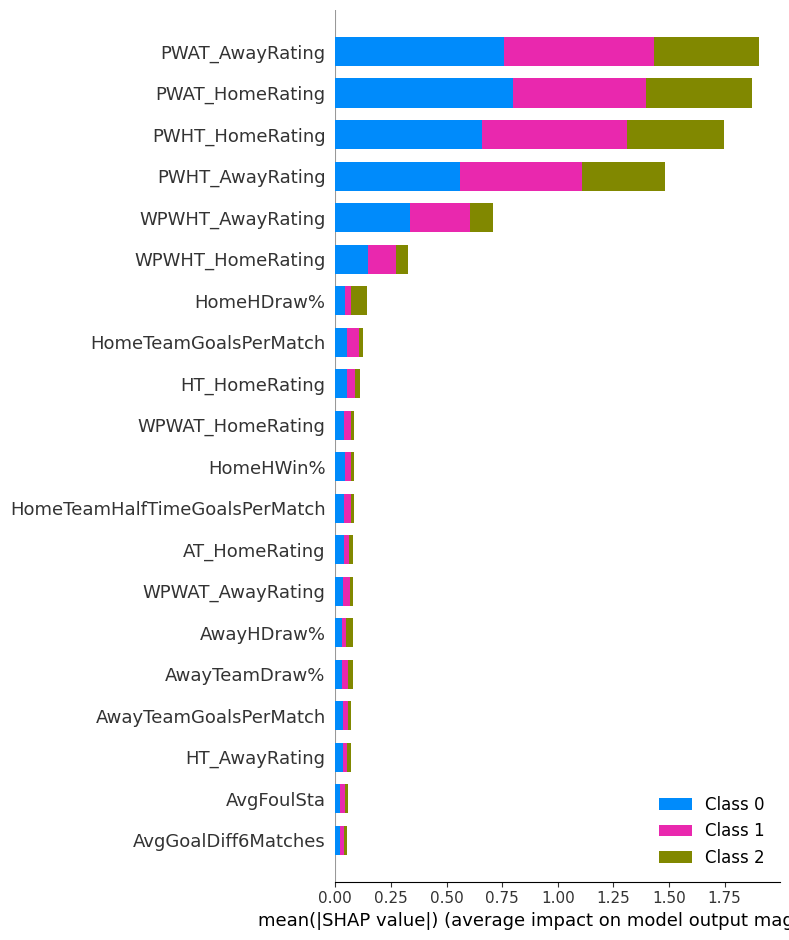

In [90]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.initjs()
shap.summary_plot(shap_values, X_train, plot_type='bar')

In [91]:
vals = np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head()

,col_name,feature_importance_vals
63,PWAT_AwayRating,96.484555
64,PWAT_HomeRating,95.036039
66,PWHT_HomeRating,88.631731
65,PWHT_AwayRating,75.134816
70,WPWHT_AwayRating,35.954028


## 6.2 Fine tuning by removing features

In [92]:
cols_to_drop = ['HomeTeamWin%','AwayTeam%', 'HomeTeamDraw%', 'AwayTeamDraw%',
                'HomeHWin%', 'HomeHDraw%', 'AwayHWin%', 'AwayHDraw%',
                'HomeTeamShotOnGoalPerMatch', 'AwayTeamShotOnGoalPerMatch',
                'HomeTeamGoalsPerMatch', 'AwayTeamGoalsPerMatch',
                'HomeTeamHalfTimeGoalsPerMatch', 'AwayTeamHalfTimeGoalsPerMatch',
                'AvgGoalDiff6Matches', 'TotalGoalDiff6Matches',
                'AvgShotSta', 'AvgTargetSta', 'AvgCornerSta', 'AvgFoulSta']

X_train_shap = X_train.copy()
X_train_shap.drop(cols_to_drop, axis=1, inplace=True)
X_test_shap = X_test.copy()
X_test_shap.drop(cols_to_drop, axis=1, inplace=True)

In [93]:
catboost_model_shap = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, loss_function='MultiClass')

# Fit the model to your training data
catboost_model_shap.fit(X_train_shap, y_train, eval_set=(X_test_shap, y_test), verbose=False)

# Make predictions on the test set
catboost_predictions = catboost_model_shap.predict(X_test_shap)

# Calculate accuracy
accuracy = accuracy_score(y_test, catboost_predictions)
print(f"Accuracy: {accuracy}")
print(catboost_predictions)

Accuracy: 0.6470588235294118
[[1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]]


In [ ]:
kfold = KFold(n_splits=10, shuffle=True,random_state=7)
results = cross_val_score(catboost_model_shap, X_train_shap, y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [66]:
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Precision: 0.4681
Recall: 0.5882
F1-Score: 0.5179


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## 6.3 SHAP adjusted model evaluation

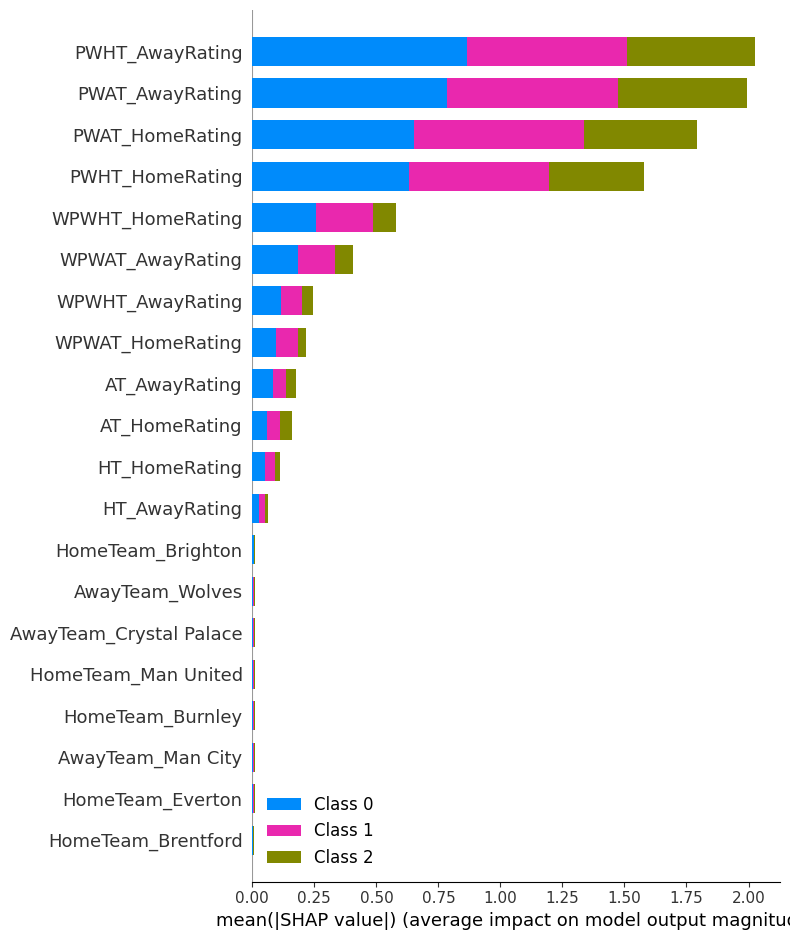

In [94]:
explainer = shap.TreeExplainer(catboost_model_shap)
shap_values = explainer.shap_values(X_train_shap)
shap.initjs()
shap.summary_plot(shap_values, X_train_shap, plot_type='bar')

In [95]:
vals = np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train_shap.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head()

,col_name,feature_importance_vals
46,PWHT_AwayRating,102.631936
44,PWAT_AwayRating,101.064602
45,PWAT_HomeRating,90.857080
47,PWHT_HomeRating,80.068320
51,WPWHT_HomeRating,29.432434


# 7. Final Predictions on Test Set

In [96]:
final_test_df = pd.read_csv('epl-test.csv')
final_test_df = final_test_df.dropna(how='all')

# Convert date to datetime
for index, row in final_test_df.iterrows():
    date = row['Date'].split('-')
    # print(date[-1])
    if len(date[-1]) == 2:
        final_test_df.at[index, 'Date'] = f'{date[0]}/{date[1]}/20{date[-1]}'
        # print(final_test_df.at[index, 'Date'])

# Match team names to the ones used in the training set
final_test_df = final_test_df.replace("Spurs", "Tottenham")
final_test_df = final_test_df.replace("Nottingham Forest", "Nott'm Forest")
final_test_df = final_test_df.replace("AFC Bournemouth", "Bournemouth")
final_test_df = final_test_df.replace("Man Utd", "Man United")
final_test_df = final_test_df.replace("Luton Town", "Luton")
final_test_df = final_test_df.replace("Sheff Utd", "Sheffield United")

final_test_df['Date'] = pd.to_datetime(final_test_df['Date'], format='mixed')
final_test_df = final_test_df.sort_values(by=['Date'])
final_test_df

,Date,HomeTeam,AwayTeam
0,2024-02-03,Bournemouth,Nott'm Forest
1,2024-02-03,Arsenal,Liverpool
2,2024-02-03,Brentford,Man City
3,2024-02-03,Brighton,Crystal Palace
4,2024-02-03,Burnley,Fulham
5,2024-02-03,Chelsea,Wolves
6,2024-02-03,Everton,Tottenham
7,2024-02-03,Man United,West Ham
8,2024-02-03,Newcastle,Luton
9,2024-02-03,Sheffield United,Aston Villa


## 7.1 Initial Model Predictions

In [97]:
final_X_test = construct_table(final_test_df, team_stats_df, away_wins_dic, home_wins_dic, away_draw_dic, home_draw_dic, data_avg, pi_ratings, pairwise_pi, weighted_pairwise_pi)
final_X_test = encode(final_X_test)

# Add any missing columns to the both sets. It could be the case that some teams haven't played home/away in the test set.
diff1 = set(final_X_test.columns) - set(X_train.columns)
diff2 = set(X_train.columns) - set(final_X_test.columns)
for col in diff1:
    X_train[col] = 0
for col in diff2:
    final_X_test[col] = 0

final_X_test = final_X_test[X_train.columns]
final_X_test.head()

,AT_AwayRating,AT_HomeRating,AvgCornerSta,AvgFoulSta,AvgGoalDiff6Matches,AvgShotSta,AvgTargetSta,AwayHDraw%,AwayHWin%,AwayTeam%,...,HomeTeam_Wolves,PWAT_AwayRating,PWAT_HomeRating,PWHT_AwayRating,PWHT_HomeRating,TotalGoalDiff6Matches,WPWAT_AwayRating,WPWAT_HomeRating,WPWHT_AwayRating,WPWHT_HomeRating
0,-0.775261,-0.578948,2.790152,3.492234,0.137500,4.639475,2.454314,12.500000,6.250000,18.750000,...,0,0.0,0.0,0.0,0.0,1.0,-0.387630,-0.289474,-0.149225,-0.088901
1,0.701563,1.009644,2.970464,3.342139,0.204167,4.870142,2.817762,26.666667,20.000000,66.666667,...,0,0.0,0.0,0.0,0.0,1.0,0.350782,0.504822,0.304060,0.368968
2,0.638488,0.796551,3.605392,3.342516,0.866667,7.164809,3.266690,6.666667,26.666667,60.000000,...,0,0.0,0.0,0.0,0.0,13.0,0.319244,0.398275,-0.020112,0.027483
3,-0.547983,-0.604720,3.382851,3.308123,1.200000,5.703901,2.960467,13.333333,20.000000,26.666667,...,0,0.0,0.0,0.0,0.0,18.0,-0.273992,-0.302360,0.050934,0.099868
4,0.008531,0.096078,2.344963,3.399797,0.400000,3.850063,1.574218,20.000000,6.666667,33.333333,...,0,0.0,0.0,0.0,0.0,6.0,0.004265,0.048039,-0.391435,-0.434154


In [98]:
final_predictions = catboost_model.predict(final_X_test)
probs = catboost_model.predict_proba(final_X_test)

In [99]:
final_test_df['FTR'] = final_predictions
final_test_df['FTR'] = final_test_df['FTR'].map({0: 'H', 1: 'A', 2: 'D'})
final_test_df['Probs'] = probs.tolist()
final_test_df

,Date,HomeTeam,AwayTeam,FTR,Probs
0,2024-02-03,Bournemouth,Nott'm Forest,A,"[0.33295510204744044, 0.3551094012392695, 0.31..."
1,2024-02-03,Arsenal,Liverpool,A,"[0.3071327684631277, 0.37175616025564984, 0.32..."
2,2024-02-03,Brentford,Man City,A,"[0.3069898127023119, 0.3702622146688393, 0.322..."
3,2024-02-03,Brighton,Crystal Palace,A,"[0.30028174842464683, 0.37132442336710175, 0.3..."
4,2024-02-03,Burnley,Fulham,A,"[0.3269681426177606, 0.37667784260947706, 0.29..."
5,2024-02-03,Chelsea,Wolves,A,"[0.3151047005620797, 0.3600306289009251, 0.324..."
6,2024-02-03,Everton,Tottenham,A,"[0.3197918500448764, 0.3615896956970721, 0.318..."
7,2024-02-03,Man United,West Ham,A,"[0.3533660268324428, 0.3863090467632907, 0.260..."
8,2024-02-03,Newcastle,Luton,A,"[0.3022428278523199, 0.38516811031237824, 0.31..."
9,2024-02-03,Sheffield United,Aston Villa,A,"[0.2892725129079169, 0.3849355487881561, 0.325..."


In [100]:
final_test_df['FTR'] = final_predictions
final_test_df['FTR'] = final_test_df['FTR'].map({0: 'H', 1: 'A', 2: 'D'})
final_test_df

,Date,HomeTeam,AwayTeam,FTR,Probs
0,2024-02-03,Bournemouth,Nott'm Forest,A,"[0.33295510204744044, 0.3551094012392695, 0.31..."
1,2024-02-03,Arsenal,Liverpool,A,"[0.3071327684631277, 0.37175616025564984, 0.32..."
2,2024-02-03,Brentford,Man City,A,"[0.3069898127023119, 0.3702622146688393, 0.322..."
3,2024-02-03,Brighton,Crystal Palace,A,"[0.30028174842464683, 0.37132442336710175, 0.3..."
4,2024-02-03,Burnley,Fulham,A,"[0.3269681426177606, 0.37667784260947706, 0.29..."
5,2024-02-03,Chelsea,Wolves,A,"[0.3151047005620797, 0.3600306289009251, 0.324..."
6,2024-02-03,Everton,Tottenham,A,"[0.3197918500448764, 0.3615896956970721, 0.318..."
7,2024-02-03,Man United,West Ham,A,"[0.3533660268324428, 0.3863090467632907, 0.260..."
8,2024-02-03,Newcastle,Luton,A,"[0.3022428278523199, 0.38516811031237824, 0.31..."
9,2024-02-03,Sheffield United,Aston Villa,A,"[0.2892725129079169, 0.3849355487881561, 0.325..."


## 7.2 SHAP adjusted model predictions

In [101]:
cols_to_drop = ['HomeTeamWin%','AwayTeam%', 'HomeTeamDraw%', 'AwayTeamDraw%',
                'HomeHWin%', 'HomeHDraw%', 'AwayHWin%', 'AwayHDraw%',
                'HomeTeamShotOnGoalPerMatch', 'AwayTeamShotOnGoalPerMatch',
                'HomeTeamGoalsPerMatch', 'AwayTeamGoalsPerMatch',
                'HomeTeamHalfTimeGoalsPerMatch', 'AwayTeamHalfTimeGoalsPerMatch',
                'AvgGoalDiff6Matches', 'TotalGoalDiff6Matches',
                'AvgShotSta', 'AvgTargetSta', 'AvgCornerSta', 'AvgFoulSta']

final_X_train_shap = final_X_test.copy()
final_X_train_shap.drop(cols_to_drop, axis=1, inplace=True)
final_X_test_shap = final_X_test.copy()
final_X_test_shap.drop(cols_to_drop, axis=1, inplace=True)

In [102]:
catboost_model_shap = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, loss_function='MultiClass')

# Fit the model to your training data
catboost_model_shap.fit(X_train_shap, y_train, eval_set=(X_test_shap, y_test), verbose=False)

# Make predictions on the test set
catboost_predictions = catboost_model_shap.predict(final_X_test_shap)
catboost_probs = catboost_model_shap.predict_proba(final_X_test_shap)

In [103]:
final_test_df['FTR'] = catboost_predictions
final_test_df['FTR'] = final_test_df['FTR'].map({0: 'H', 1: 'A', 2: 'D'})
final_test_df['HomeTeamWin%'] = catboost_probs[:, 0]
final_test_df['AwayTeam%'] = catboost_probs[:, 1]
final_test_df['Draw%'] = catboost_probs[:, 2]
final_test_df

,Date,HomeTeam,AwayTeam,FTR,Probs,HomeTeamWin%,AwayTeam%,Draw%
0,2024-02-03,Bournemouth,Nott'm Forest,H,"[0.33295510204744044, 0.3551094012392695, 0.31...",0.378080,0.358826,0.263095
1,2024-02-03,Arsenal,Liverpool,A,"[0.3071327684631277, 0.37175616025564984, 0.32...",0.325882,0.404749,0.269369
2,2024-02-03,Brentford,Man City,H,"[0.3069898127023119, 0.3702622146688393, 0.322...",0.376167,0.358678,0.265155
3,2024-02-03,Brighton,Crystal Palace,H,"[0.30028174842464683, 0.37132442336710175, 0.3...",0.383599,0.356836,0.259565
4,2024-02-03,Burnley,Fulham,A,"[0.3269681426177606, 0.37667784260947706, 0.29...",0.350285,0.382998,0.266717
5,2024-02-03,Chelsea,Wolves,H,"[0.3151047005620797, 0.3600306289009251, 0.324...",0.384549,0.330225,0.285227
6,2024-02-03,Everton,Tottenham,H,"[0.3197918500448764, 0.3615896956970721, 0.318...",0.403358,0.334168,0.262475
7,2024-02-03,Man United,West Ham,H,"[0.3533660268324428, 0.3863090467632907, 0.260...",0.369425,0.347431,0.283144
8,2024-02-03,Newcastle,Luton,H,"[0.3022428278523199, 0.38516811031237824, 0.31...",0.366599,0.350688,0.282712
9,2024-02-03,Sheffield United,Aston Villa,A,"[0.2892725129079169, 0.3849355487881561, 0.325...",0.310499,0.428578,0.260923
